# Regression Implementation

In [41]:
# Import necessary libraries
try:
    import os
    import glob
    import torch
    import joblib
    import pandas as pd
    import numpy as np

    import seaborn as sns
    from scipy import stats
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from scipy.signal import savgol_filter
    from itertools import groupby

    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import (
        PolynomialFeatures,
        StandardScaler,
        OneHotEncoder,
        LabelEncoder
    )
    from sklearn.compose import ColumnTransformer
    from sklearn.utils import class_weight
    from sklearn.linear_model import (
        LinearRegression, LogisticRegression        # Baseline models
    )
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor
    from sklearn.cluster import KMeans
    from kneed import KneeLocator
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error,
        root_mean_squared_error,
        classification_report,
        confusion_matrix,
        accuracy_score,
        silhouette_score,
        r2_score
    )
    from imblearn.over_sampling import SMOTE

    # TensorFlow and Keras for the Neural Network
    import keras
    import tensorflow as tf
    from tensorflow.keras.models import Sequential                            # type: ignore
    from tensorflow.keras import layers, models, regularizers                 # type: ignore
    from tensorflow.keras.layers import (                                     # type: ignore
        Dense, Dropout, BatchNormalization, Input
    )
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau   # type: ignore
    from tensorflow.keras.optimizers import Adam                              # type: ignore

    # Set random seeds for reproducibility
    random_state = 42
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

except Exception as e:
    print(f"Error importing libraries: {e}")

In [42]:
# Set the model saving path
destination = '../Models/'                       # Destination folder for the model
os.makedirs(destination, exist_ok=True)          # Create the folder if it doesn't exist
print(f"Model will be saved to: {destination}")  # Output the model destination folder

Model will be saved to: ../Models/


In [43]:
# Define color palette for the plots
green = '#2ECC71'  # Green
blue = '#3498DB'   # Blue
red = '#E74C3C'    # Red

Custom functions for the notebook

In [44]:
def regression_evaluation(model, X, y, message="Model", scale=False):
    if scale:
        scaler = StandardScaler()
        X = pd.DataFrame(
            scaler.fit_transform(X),
            columns=X.columns,
            index=X.index
        )

    # Get predictions
    predictions = model.predict(X)
    
    # Calculate residuals
    residuals = y - predictions
    
    # Calculate metrics
    rmse = root_mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    
    # Print evaluation metrics
    print(f"--- {message} Evaluation Metrics ---\n")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.2f}")
    print(f"MAE : {mae:.2f}")
    
    # Set style
    plt.style.use('default')
    
    # Create figure with three subplots
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    fig.suptitle(f'Regression Model Evaluation - {message}', fontsize=14, y=1.05)
    
    # Color palette
    actual_color = '#2ECC71'  # Green
    pred_color = '#3498DB'    # Blue
    trend_color = '#E74C3C'   # Red
    
    # Plot 1: Actual vs Predicted
    line_x = np.linspace(y.min(), y.max(), 100)
    
    ax1.scatter(y, predictions, alpha=0.5, color=pred_color, label='Predictions', s=100)
    ax1.plot(line_x, line_x, '--', color='gray', alpha=0.8, label='Perfect Prediction', linewidth=2)
    
    z = np.polyfit(y, predictions, 1)
    p = np.poly1d(z)
    ax1.plot(line_x, p(line_x), '-', color=trend_color, alpha=0.8, label='Trend Line')
    
    ax1.set_xlabel('Actual Values', fontsize=12)
    ax1.set_ylabel('Predicted Values', fontsize=12)
    ax1.set_title('Actual vs Predicted Values', fontsize=13, pad=15)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    ax2.scatter(predictions, residuals, alpha=0.5, color=pred_color, s=100)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.8)
    
    z = np.polyfit(predictions, residuals, 1)
    p = np.poly1d(z)
    ax2.plot(predictions, p(predictions), color=trend_color, alpha=0.8, label='Trend Line')
    
    ax2.set_xlabel('Predicted Values', fontsize=12)
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.set_title('Residuals Plot', fontsize=13, pad=15)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    std_dev = np.std(residuals)
    ax2.axhline(y=std_dev, color=trend_color, linestyle=':', alpha=0.5, label='+1 Std Dev')
    ax2.axhline(y=-std_dev, color=trend_color, linestyle=':', alpha=0.5, label='-1 Std Dev')
    
    # Plot 3: Model Fit Visualization
    # Sort by target values for smooth curve
    sort_idx = np.argsort(y)
    y_sorted = y.iloc[sort_idx]
    pred_sorted = predictions[sort_idx]
    
    # Create index for x-axis
    x_range = np.arange(len(y))
    
    # Plot actual and predicted values
    ax3.scatter(x_range, y_sorted, alpha=0.5, color=actual_color, label='Actual Values', s=100)
    ax3.scatter(x_range, pred_sorted, alpha=0.5, color=pred_color, label='Predictions', s=100)
    
    # Add smoothed curve through predictions
    window = len(y) // 20  # Adjust window size as needed
    if window % 2 == 0:
        window += 1
    smoothed = savgol_filter(pred_sorted, window, 3)
    ax3.plot(x_range, smoothed, '-', color=trend_color, alpha=0.8, label='Model Fit', linewidth=2)
    
    ax3.set_xlabel('Ordered Samples', fontsize=12)
    ax3.set_ylabel('Values', fontsize=12)
    ax3.set_title('Model Fit Visualization', fontsize=13, pad=15)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage:
# regression_evaluation(model, X_test, y_test, "Linear Regression Model (Test Set)")

In [45]:
# Utility function to load dataset
def load_dataset(data_path='../Datasets/*.csv'):       # Dynamically load dataset from the Datasets directory
    file_list = glob.glob(data_path)
    if len(file_list) == 1:
        df = pd.read_csv(file_list[0])
        print(f"Loaded dataset: {file_list[0]}")
    else:
        raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")
    return df

In [46]:
# Load the dataset
df = load_dataset()

Loaded dataset: ../Datasets/Dataset.csv


In [47]:
df.head()

Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1469.17   Nozzle      equiGrain           13        3.84       6.47   
1   1793.64    Block    singleGrain           19        2.62       3.48   
2    700.60    Blade      equiGrain           28        0.76       1.34   
3   1082.10   Nozzle       colGrain            9        2.01       2.19   
4   1838.83    Blade       colGrain           16        4.13       3.87   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          46.87    65.73  16.52    16.82       0.93            10   
1          44.70    54.22  35.38     6.14       4.26            19   
2           9.54    51.83  35.95     8.81       3.41            35   
3          20.29    57.03  23.33    16.86       2.78             0   
4          16.13    59.62  27.37    11.45       1.56            10   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0       Bottom         Die  
1             0              0       Bottom  Investment  
2             3              0       Bottom  Investment  
3             1              0          Top  Continuous  
4             0              0          Top         Die

In [48]:
df.describe()

Lifespan  coolingRate   quenchTime    forgeTime  HeatTreatTime  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000   
mean   1298.556320    17.639000     2.764230     5.464600      30.194510   
std     340.071434     7.491783     1.316979     2.604513      16.889415   
min     417.990000     5.000000     0.500000     1.030000       1.030000   
25%    1047.257500    11.000000     1.640000     3.170000      16.185000   
50%    1266.040000    18.000000     2.755000     5.475000      29.365000   
75%    1563.050000    24.000000     3.970000     7.740000      44.955000   
max    2134.530000    30.000000     4.990000    10.000000      59.910000   

           Nickel%        Iron%      Cobalt%    Chromium%  smallDefects  \
count  1000.000000  1000.000000  1000.000000  1000.000000   1000.000000   
mean     60.243080    24.553580    12.434690     2.768650     17.311000   
std       5.790475     7.371737     4.333197     1.326496     12.268365   
min      50.020000     6.660000     5.020000     0.510000      0.000000   
25%      55.287500    19.387500     8.597500     1.590000      7.000000   
50%      60.615000    24.690000    12.585000     2.865000     18.000000   
75%      65.220000    29.882500    16.080000     3.922500     26.000000   
max      69.950000    43.650000    19.990000     4.990000     61.000000   

       largeDefects  sliverDefects  
count   1000.000000    1000.000000  
mean       0.550000       0.292000  
std        1.163982       1.199239  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.000000       0.000000  
75%        0.000000       0.000000  
max        4.000000       8.000000

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lifespan        1000 non-null   float64
 1   partType        1000 non-null   object 
 2   microstructure  1000 non-null   object 
 3   coolingRate     1000 non-null   int64  
 4   quenchTime      1000 non-null   float64
 5   forgeTime       1000 non-null   float64
 6   HeatTreatTime   1000 non-null   float64
 7   Nickel%         1000 non-null   float64
 8   Iron%           1000 non-null   float64
 9   Cobalt%         1000 non-null   float64
 10  Chromium%       1000 non-null   float64
 11  smallDefects    1000 non-null   int64  
 12  largeDefects    1000 non-null   int64  
 13  sliverDefects   1000 non-null   int64  
 14  seedLocation    1000 non-null   object 
 15  castType        1000 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 125.1+ KB


In [50]:
df.shape

(1000, 16)

In [51]:
# Check for missing values
df.isnull().sum()

Lifespan          0
partType          0
microstructure    0
coolingRate       0
quenchTime        0
forgeTime         0
HeatTreatTime     0
Nickel%           0
Iron%             0
Cobalt%           0
Chromium%         0
smallDefects      0
largeDefects      0
sliverDefects     0
seedLocation      0
castType          0
dtype: int64

In [52]:
# Using nunique()
num_parts = df['partType'].nunique()
print(f"Number of unique parts types: {num_parts}")

# Or using value_counts() to see the distribution
parts_distribution = df['partType'].value_counts()
print("\nDistribution of parts types:")
print(parts_distribution)

Number of unique parts types: 4

Distribution of parts types:
partType
Valve     265
Block     253
Nozzle    245
Blade     237
Name: count, dtype: int64


In [53]:
unique_lifespan_count = df['Lifespan'].nunique()
print(f"Number of unique values in 'Lifespan' column: {unique_lifespan_count}")

Number of unique values in 'Lifespan' column: 998


In [54]:
# Find the unique values that occur more than once in the 'Lifespan' column
duplicate_values = df['Lifespan'].value_counts()
duplicate_values = duplicate_values[duplicate_values > 1]

# Output the unique values and their counts
print(duplicate_values)

Lifespan
1262.14    2
932.69     2
Name: count, dtype: int64


We have found that there are 4 disticnt metal parts in this dataset.

### Distribution of Lifespan

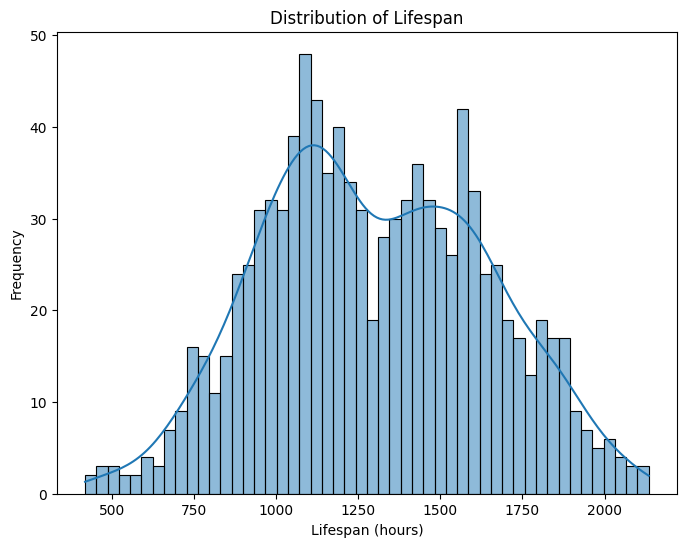

In [55]:
bins = 50

# Plotting the distribution of 'Lifespan'
plt.figure(figsize=(8, 6))
sns.histplot(df['Lifespan'], bins=bins, kde=True)
plt.title('Distribution of Lifespan')
plt.xlabel('Lifespan (hours)')
plt.ylabel('Frequency')
plt.show()

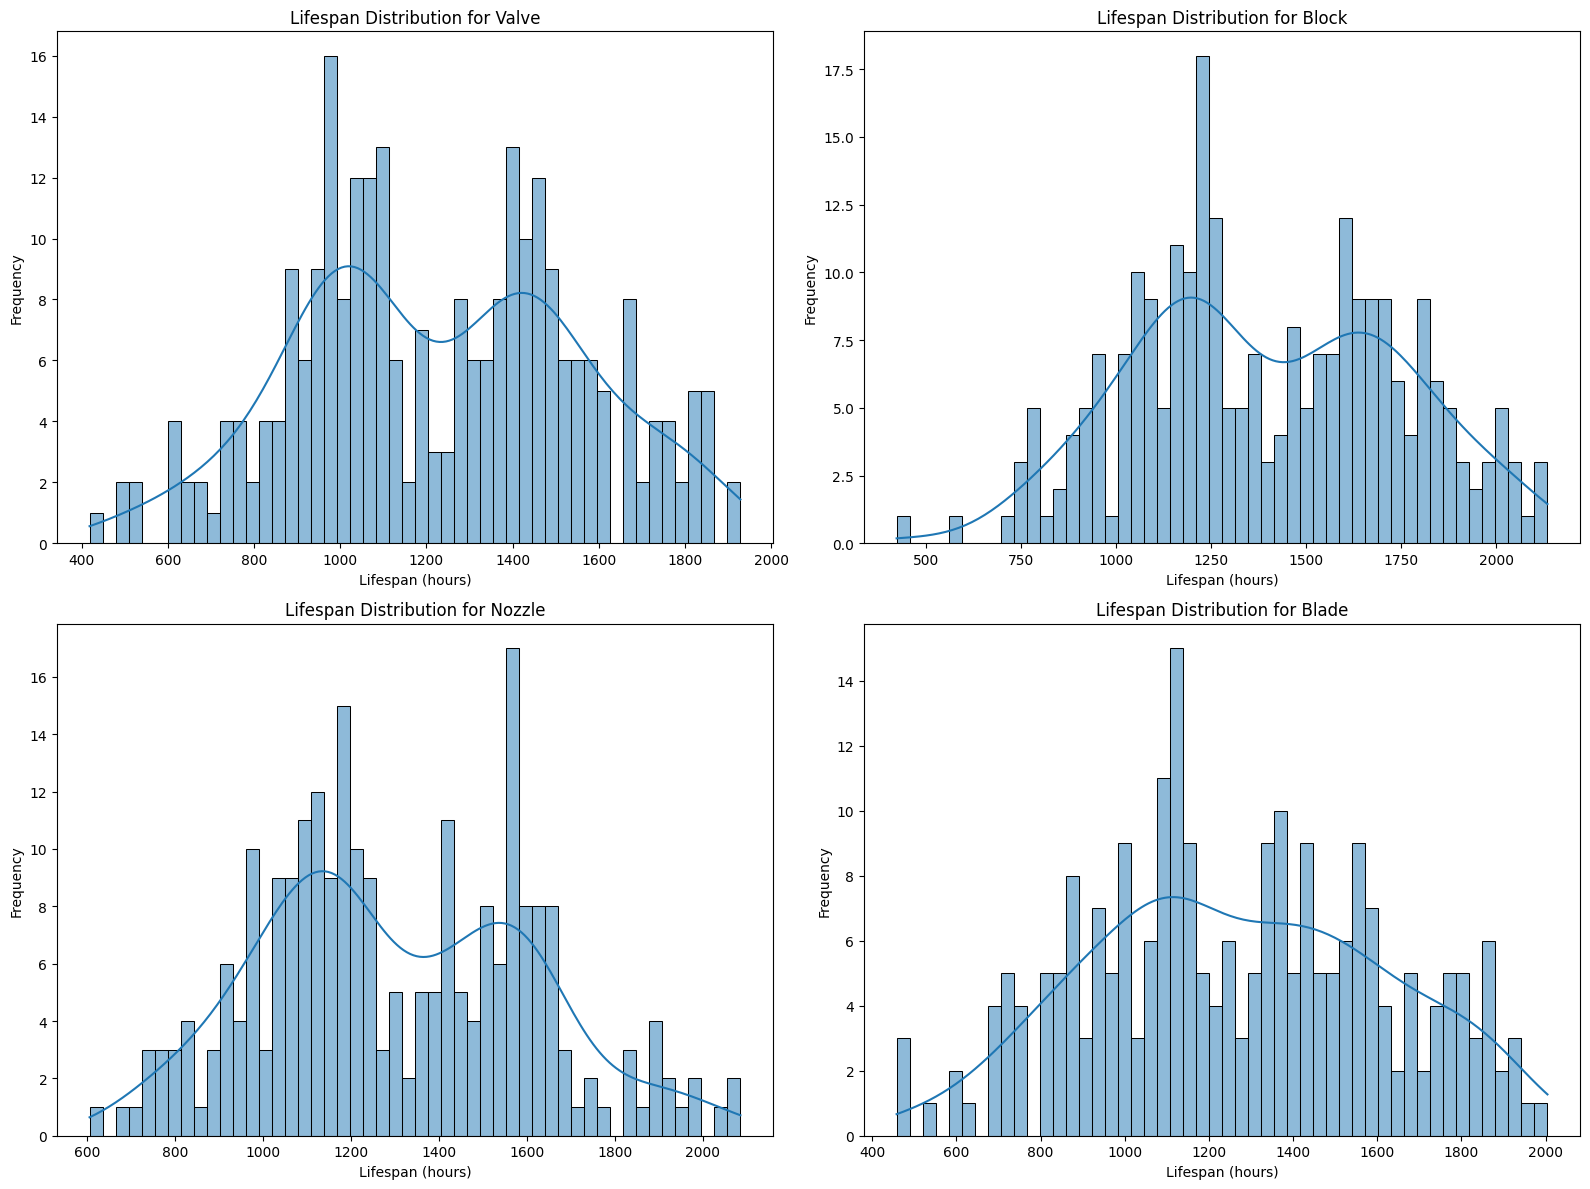

In [56]:
# List of metal parts
part_types = ['Valve', 'Block', 'Nozzle', 'Blade']

# Set up the subplots: 2 rows and 2 columns (one for each metal part)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each metal part and create a histogram for its lifespan distribution
for i, part in enumerate(part_types):
    subset = df[df['partType'] == part]
    sns.histplot(subset['Lifespan'], bins=bins, kde=True, ax=axes[i])
    axes[i].set_title(f'Lifespan Distribution for {part}')
    axes[i].set_xlabel('Lifespan (hours)')
    axes[i].set_ylabel('Frequency')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [57]:
# List of numerical columns excluding 'Lifespan'
numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'Lifespan']
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

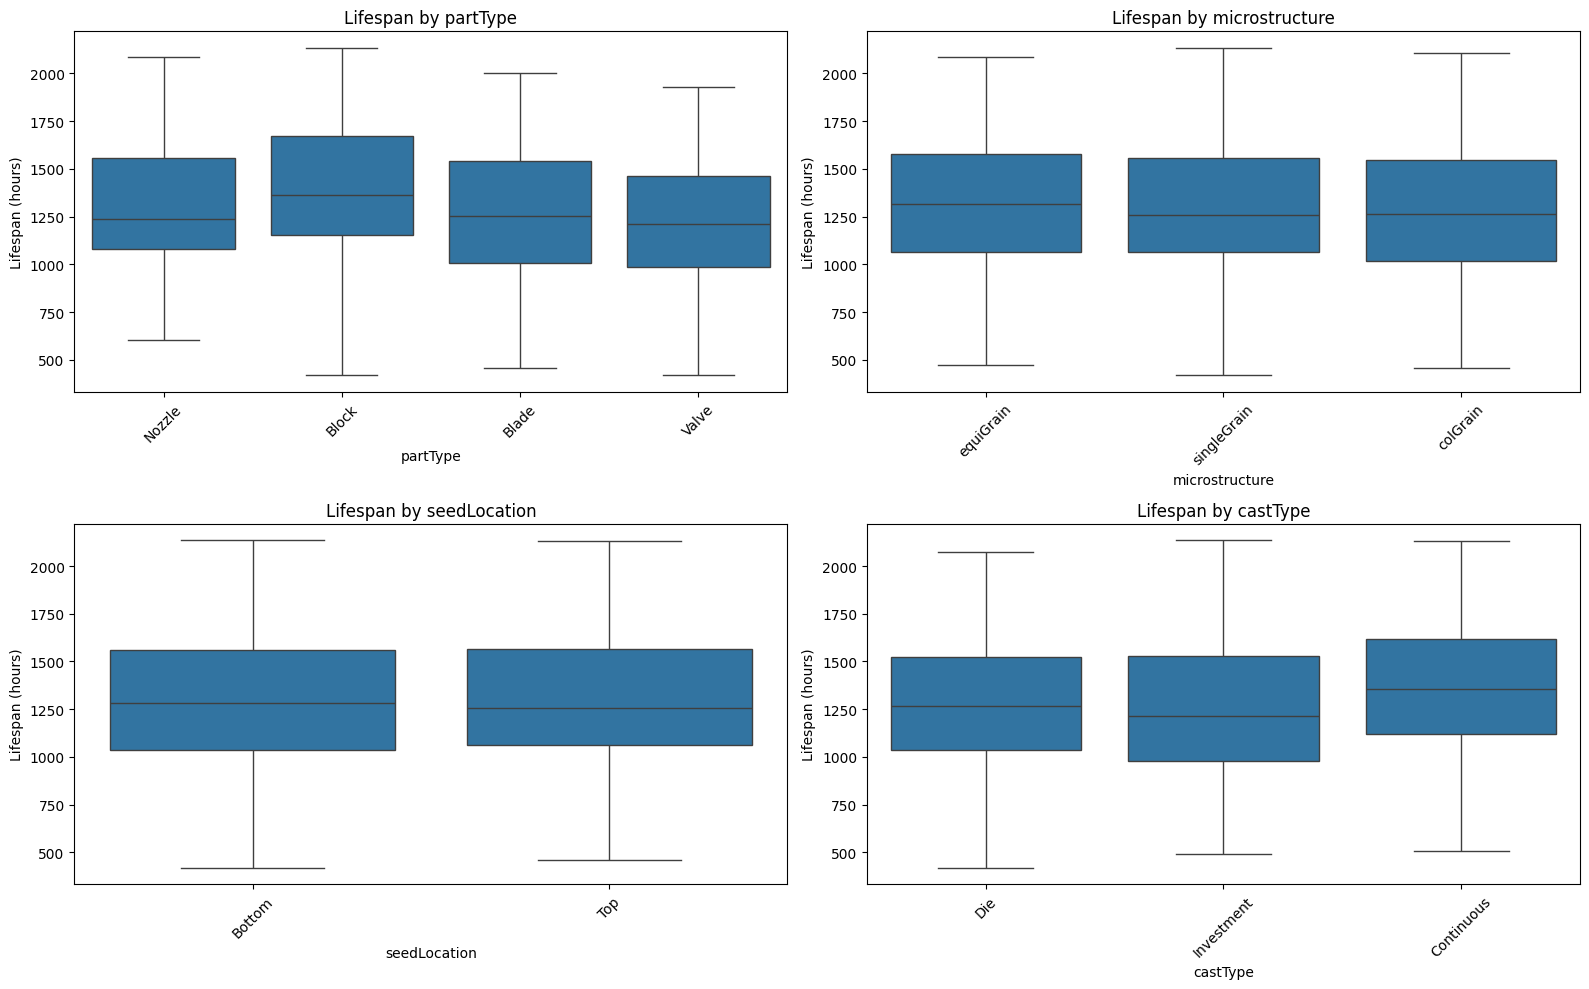

In [58]:
# Determine the number of rows and columns for the subplots
num_cols = len(categorical_features)
nrows = num_cols // 2 + (num_cols % 2 > 0)  # Set up for 2 columns per row for better readability

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, nrows * 5))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Plot each boxplot in a different subplot
for i, col in enumerate(categorical_features):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=df)
    axes[i].set_title(f'Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of features is odd
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

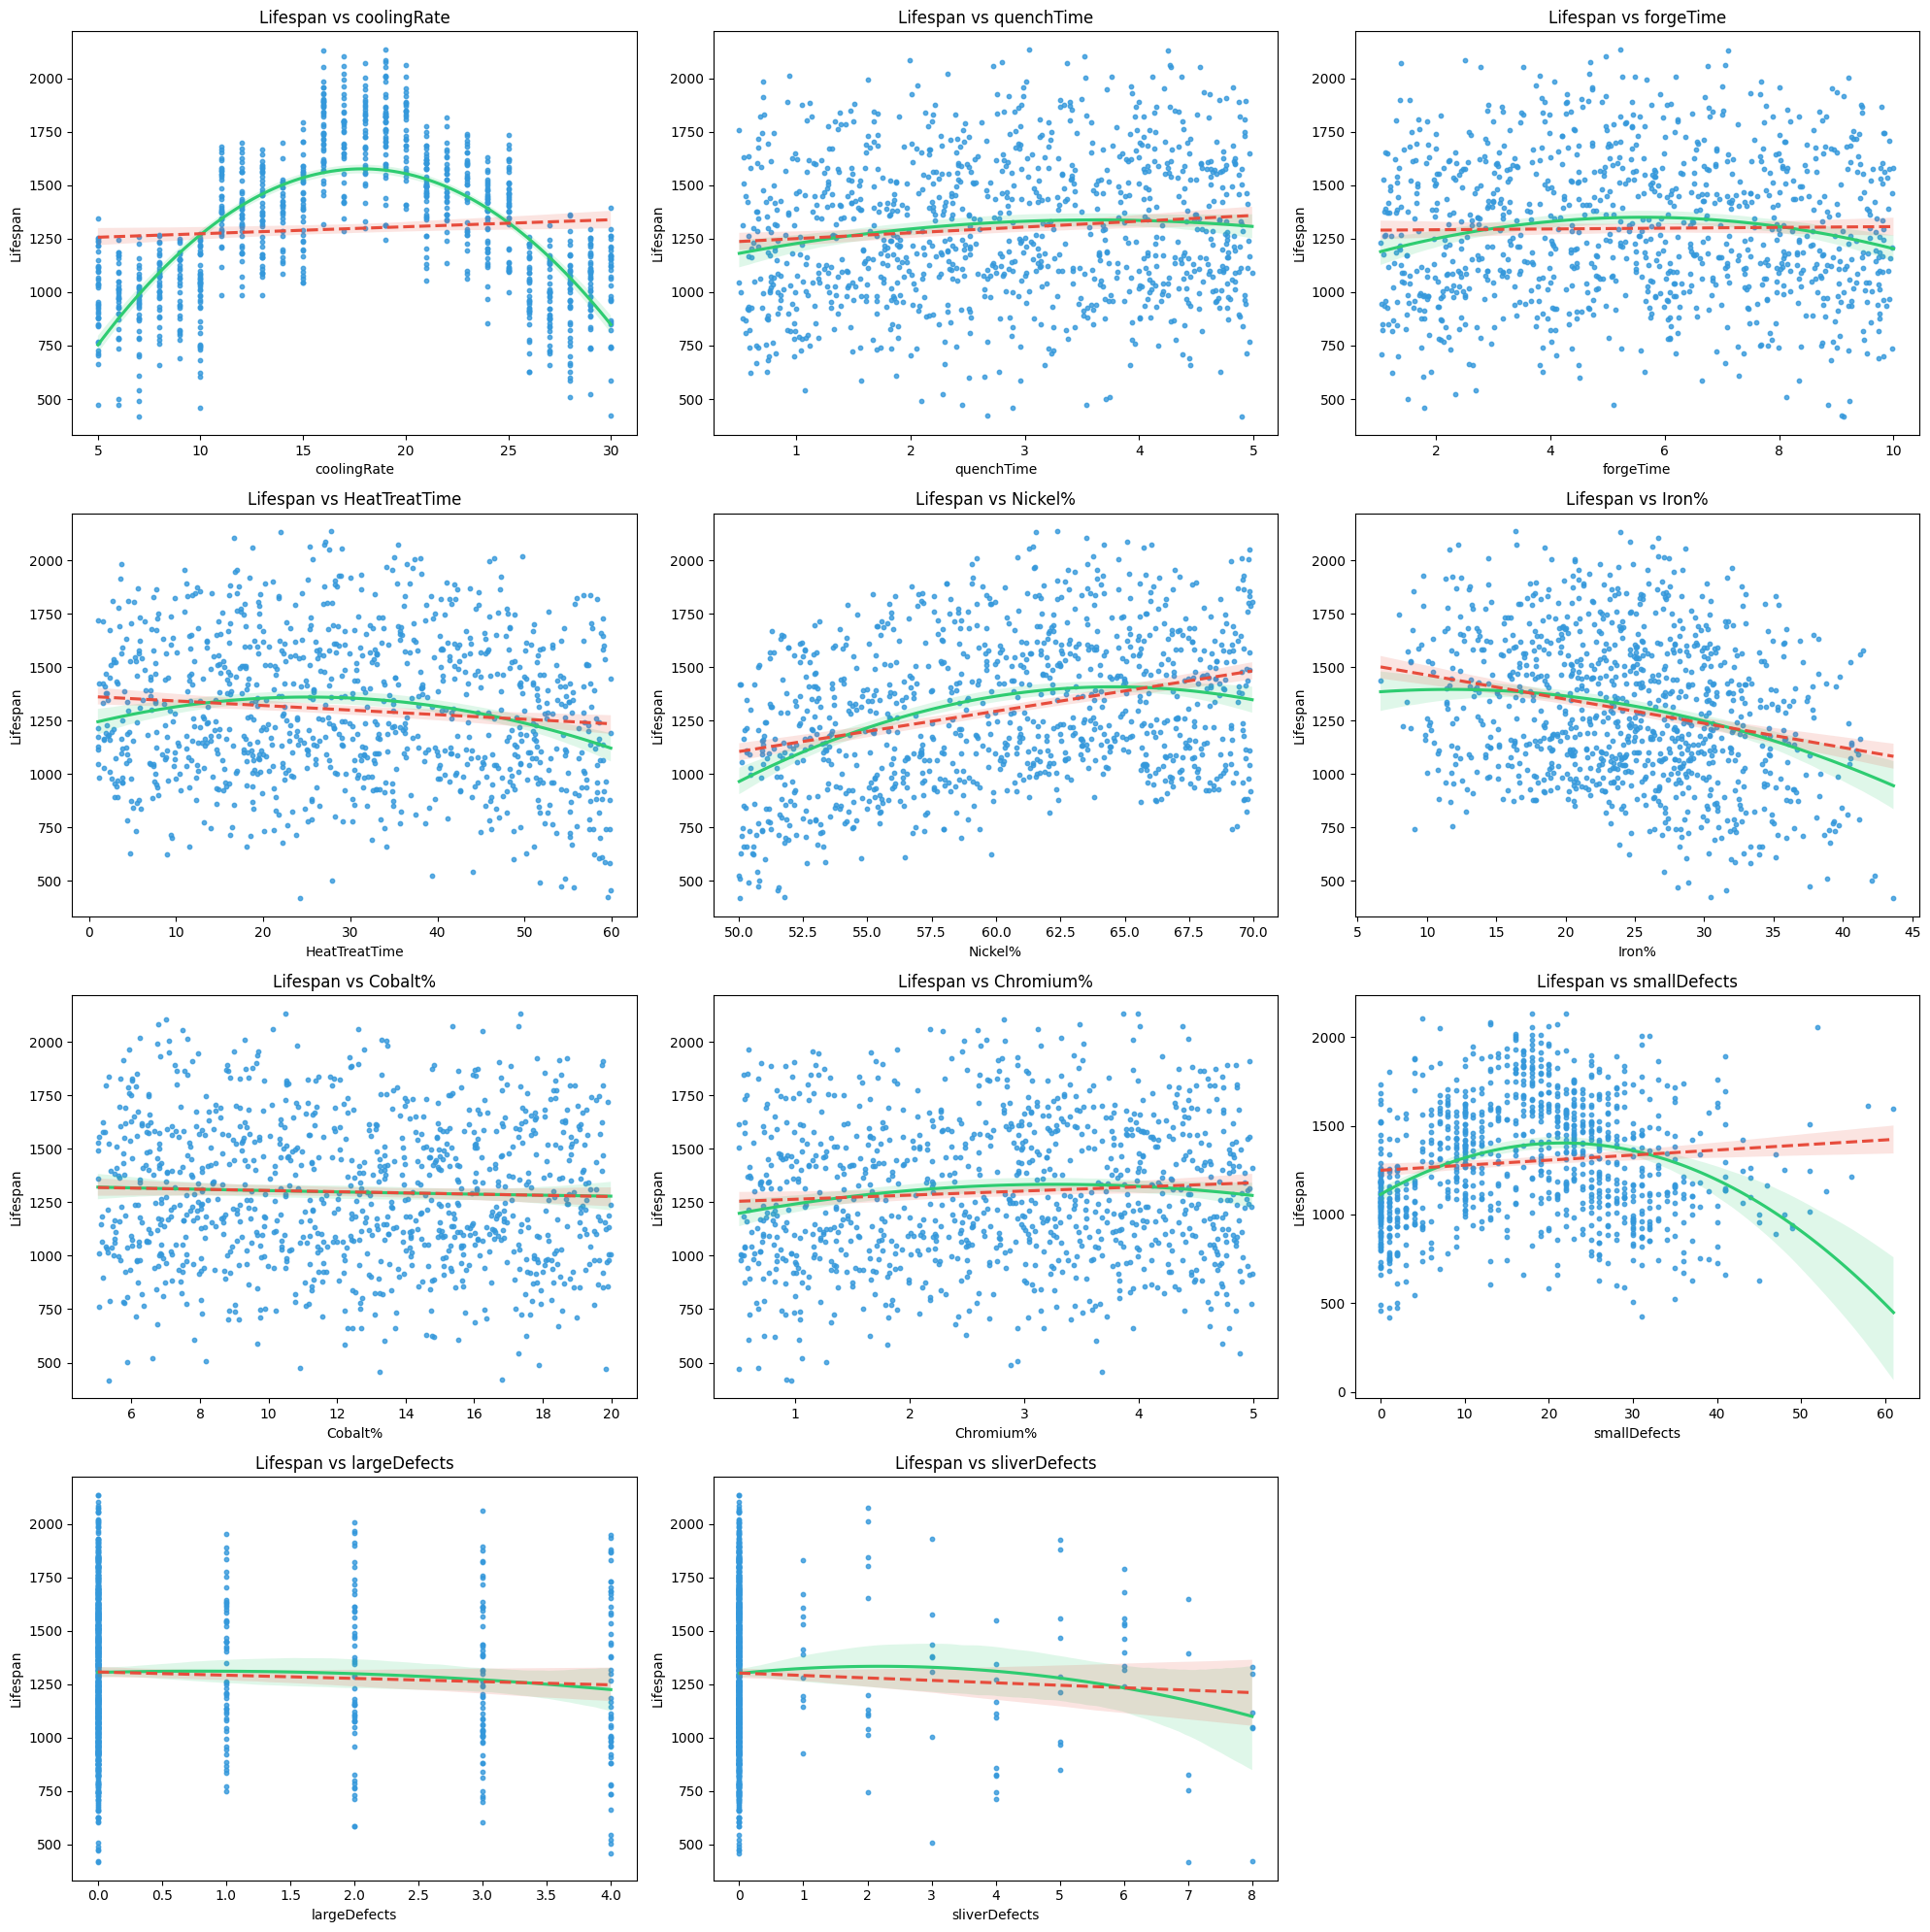

In [59]:
# Determine the number of rows and columns for the subplots
num_cols = len(numerical_features)
nrows = num_cols // 3 + (num_cols % 3 > 0)  # Set up for 3 columns per row

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows * 5))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot each scatterplot with a polynomial regression trend line in a different subplot
for i, col in enumerate(numerical_features):
    sns.regplot(
        ax=axes[i],
        data=df,
        x=col,
        y='Lifespan',
        scatter_kws={'s': 10, 'color': blue},  # Set scatter plot color to blue
        line_kws={'color': green},
        order=2  # Using polynomial order 2 to create a curved trend line
    )
    axes[i].set_title(f'Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')

    # Linear regression line
    sns.regplot(ax=axes[i], data=df, x=col, y='Lifespan', scatter=False, line_kws={'color': red, 'linestyle': '--'})

# Remove any empty subplots if the number of features is not perfectly divisible by 3
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

There is a parabolic (U-shaped) trend visible, which confirms your earlier findings. This suggests that there is an optimal cooling rate where the lifespan reaches a peak, beyond which the lifespan decreases. A quadratic relationship fits well here.

In [60]:
# Define features to transform
features_to_transform = {
    'coolingRate': 7,
    'forgeTime': 2,
    'HeatTreatTime': 2,
    'smallDefects': 3,
    'sliverDefects': 2
}

# Keep a copy of original features
df_transformed = df.copy()

# Transform features using PolynomialFeatures
for feature, degree in features_to_transform.items():
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[[feature]])
    
    # Get column names for the new polynomial features
    poly_feature_names = [f"{feature}^{{{i}}}" for i in range(1, degree + 1)]
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    
    # Drop the original feature and add polynomial features to the dataset
    df_transformed = df_transformed.drop(columns=[feature]).join(poly_df)

# Adding linear features that were not transformed back to the transformed DataFrame
# Only add features that were not involved in polynomial transformation
linear_features = ['quenchTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'largeDefects']
df_transformed = df_transformed[linear_features + [col for col in df_transformed.columns if col not in linear_features]]

# The df_transformed now contains both the polynomial and linear features without redundancy
display(df_transformed.head())
display(df.head())

quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
0        3.84    65.73  16.52    16.82       0.93             0   1469.17   
1        2.62    54.22  35.38     6.14       4.26             0   1793.64   
2        0.76    51.83  35.95     8.81       3.41             3    700.60   
3        2.01    57.03  23.33    16.86       2.78             1   1082.10   
4        4.13    59.62  27.37    11.45       1.56             0   1838.83   

  partType microstructure seedLocation  ... coolingRate^{7}  forgeTime^{1}  \
0   Nozzle      equiGrain       Bottom  ...    6.274852e+07           6.47   
1    Block    singleGrain       Bottom  ...    8.938717e+08           3.48   
2    Blade      equiGrain       Bottom  ...    1.349293e+10           1.34   
3   Nozzle       colGrain          Top  ...    4.782969e+06           2.19   
4    Blade       colGrain          Top  ...    2.684355e+08           3.87   

   forgeTime^{2}  HeatTreatTime^{1}  HeatTreatTime^{2}  smallDefects^{1}  \
0        41.8609              46.87          2196.7969              10.0   
1        12.1104              44.70          1998.0900              19.0   
2         1.7956               9.54            91.0116              35.0   
3         4.7961              20.29           411.6841               0.0   
4        14.9769              16.13           260.1769              10.0   

   smallDefects^{2}  smallDefects^{3}  sliverDefects^{1}  sliverDefects^{2}  
0             100.0            1000.0                0.0                0.0  
1             361.0            6859.0                0.0                0.0  
2            1225.0           42875.0                0.0                0.0  
3               0.0               0.0                0.0                0.0  
4             100.0            1000.0                0.0                0.0  

[5 rows x 27 columns]

Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1469.17   Nozzle      equiGrain           13        3.84       6.47   
1   1793.64    Block    singleGrain           19        2.62       3.48   
2    700.60    Blade      equiGrain           28        0.76       1.34   
3   1082.10   Nozzle       colGrain            9        2.01       2.19   
4   1838.83    Blade       colGrain           16        4.13       3.87   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          46.87    65.73  16.52    16.82       0.93            10   
1          44.70    54.22  35.38     6.14       4.26            19   
2           9.54    51.83  35.95     8.81       3.41            35   
3          20.29    57.03  23.33    16.86       2.78             0   
4          16.13    59.62  27.37    11.45       1.56            10   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0       Bottom         Die  
1             0              0       Bottom  Investment  
2             3              0       Bottom  Investment  
3             1              0          Top  Continuous  
4             0              0          Top         Die

In [61]:
def print_transformed_columns_info(df_transformed):
    for col in df_transformed.columns:
        print(f"- {col}")
    print(f"Number of columns: {len(df_transformed.columns)}")

# Call the function to print the transformed columns info
print_transformed_columns_info(df_transformed)

- quenchTime
- Nickel%
- Iron%
- Cobalt%
- Chromium%
- largeDefects
- Lifespan
- partType
- microstructure
- seedLocation
- castType
- coolingRate^{1}
- coolingRate^{2}
- coolingRate^{3}
- coolingRate^{4}
- coolingRate^{5}
- coolingRate^{6}
- coolingRate^{7}
- forgeTime^{1}
- forgeTime^{2}
- HeatTreatTime^{1}
- HeatTreatTime^{2}
- smallDefects^{1}
- smallDefects^{2}
- smallDefects^{3}
- sliverDefects^{1}
- sliverDefects^{2}
Number of columns: 27


In [62]:
df1_test = df_transformed[['coolingRate^{1}', 'forgeTime^{1}', 'HeatTreatTime^{1}', 'smallDefects^{1}', 'sliverDefects^{1}']]
df2_test = df_transformed[['coolingRate^{6}', 'forgeTime^{2}', 'HeatTreatTime^{2}', 'smallDefects^{3}', 'sliverDefects^{2}']]

display(df1_test.head())
display(df2_test.head())

coolingRate^{1}  forgeTime^{1}  HeatTreatTime^{1}  smallDefects^{1}  \
0             13.0           6.47              46.87              10.0   
1             19.0           3.48              44.70              19.0   
2             28.0           1.34               9.54              35.0   
3              9.0           2.19              20.29               0.0   
4             16.0           3.87              16.13              10.0   

   sliverDefects^{1}  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

coolingRate^{6}  forgeTime^{2}  HeatTreatTime^{2}  smallDefects^{3}  \
0        4826809.0        41.8609          2196.7969            1000.0   
1       47045881.0        12.1104          1998.0900            6859.0   
2      481890304.0         1.7956            91.0116           42875.0   
3         531441.0         4.7961           411.6841               0.0   
4       16777216.0        14.9769           260.1769            1000.0   

   sliverDefects^{2}  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

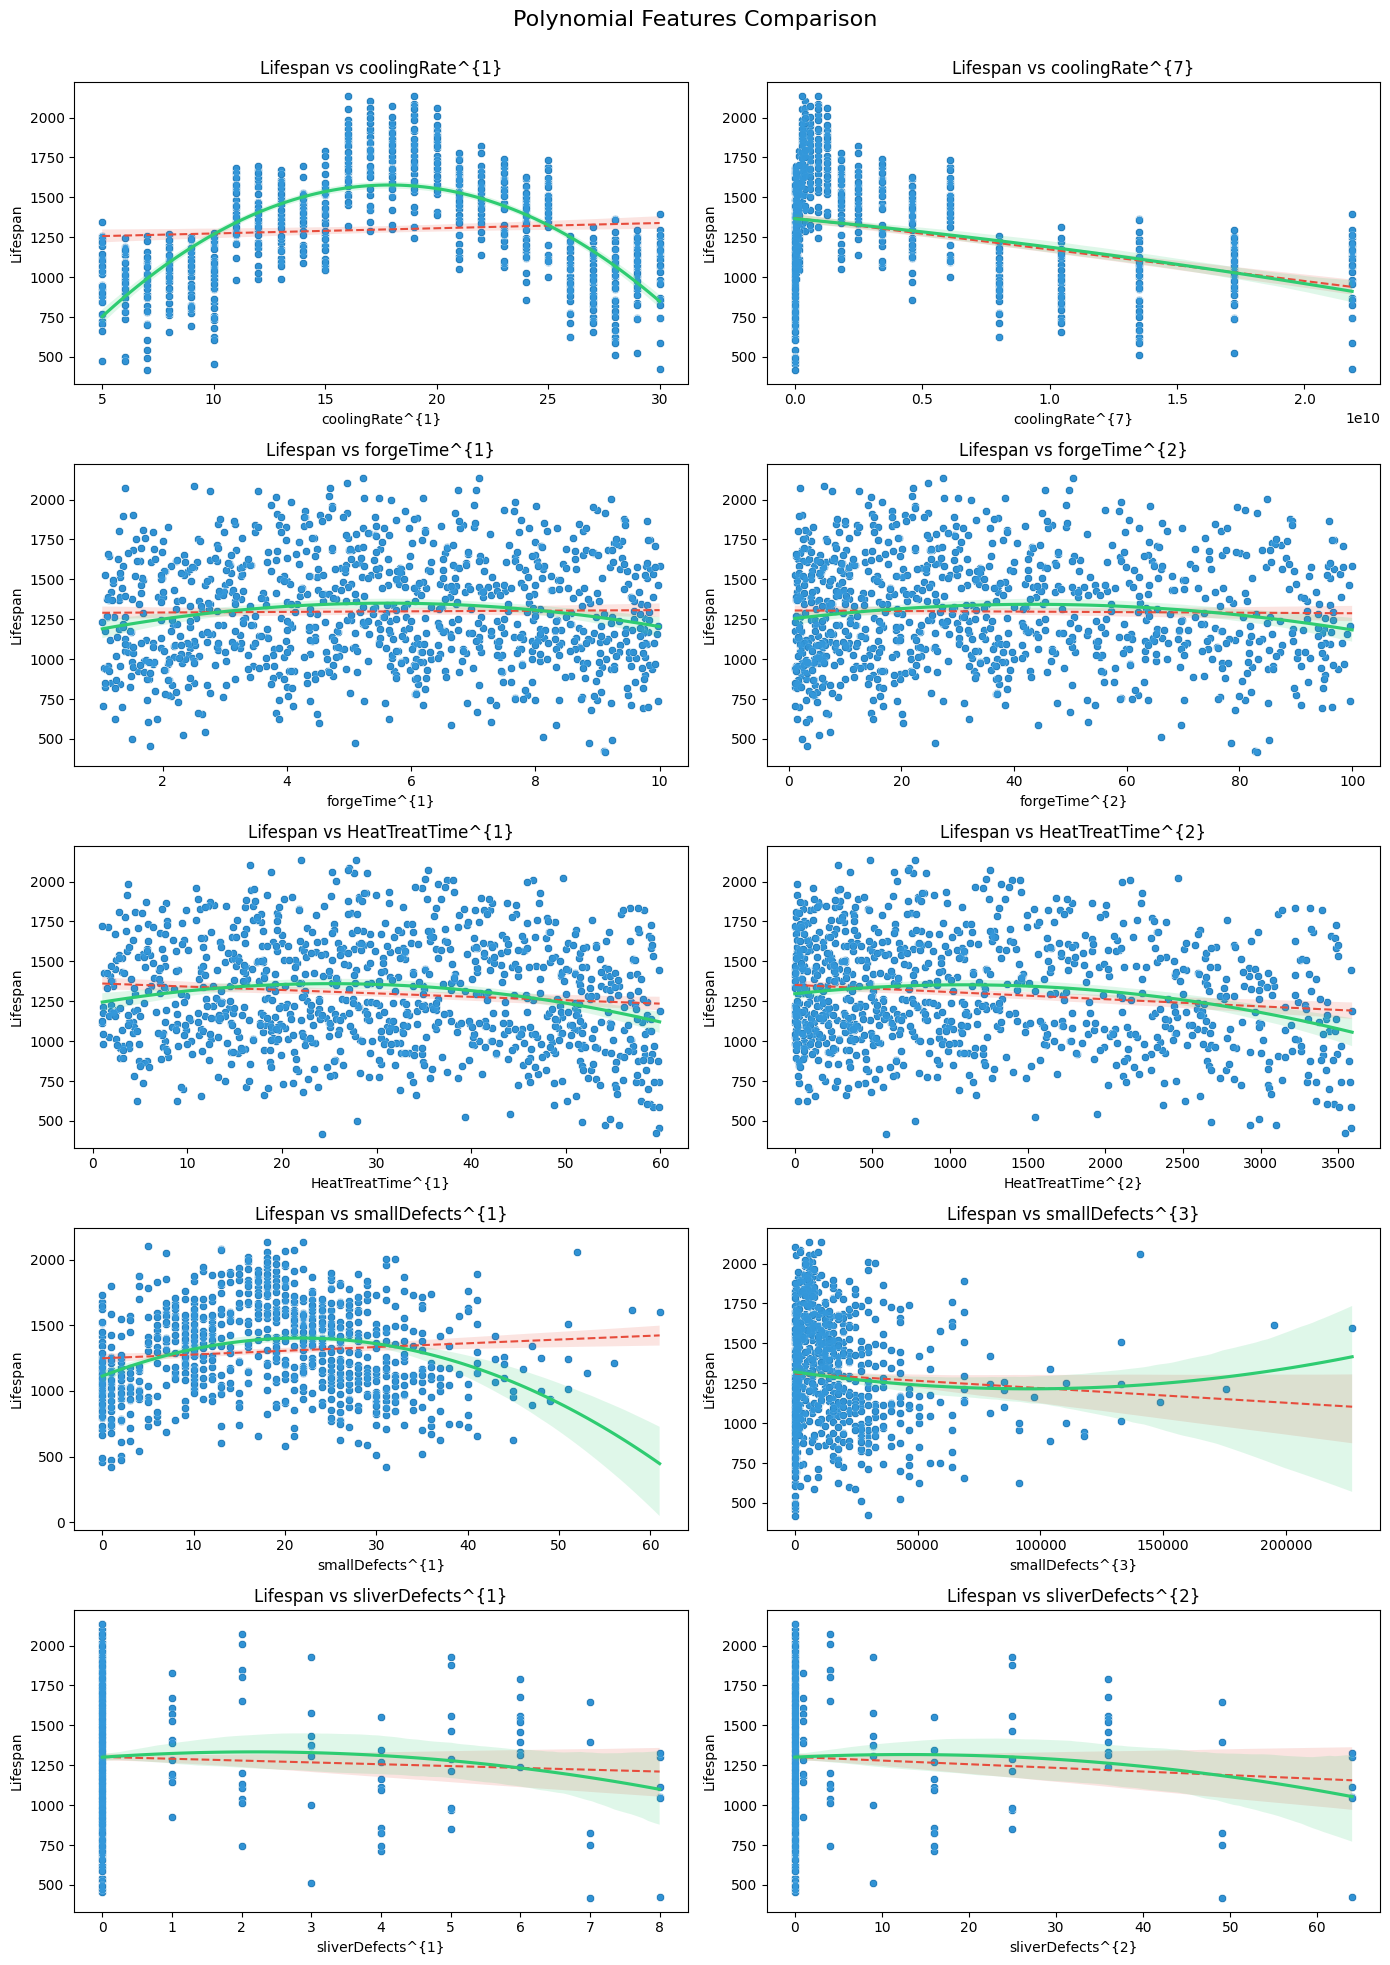

In [63]:
# Scatter plots for the newly added polynomial features vs. Lifespan.

# List of newly created polynomial features
polynomial_features = [
    'coolingRate^{1}', 'coolingRate^{7}', 
    'forgeTime^{1}', 'forgeTime^{2}', 
    'HeatTreatTime^{1}', 'HeatTreatTime^{2}', 
    'smallDefects^{1}', 'smallDefects^{3}', 
    'sliverDefects^{1}', 'sliverDefects^{2}'
]

# Number of rows and columns for the plot grid
n_cols = 2
n_rows = len(polynomial_features) // n_cols + (len(polynomial_features) % n_cols > 0)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

# Plot each polynomial feature against 'Lifespan'
for i, feature in enumerate(polynomial_features):
    row, col = divmod(i, n_cols)
    sns.scatterplot(ax=axes[row, col], x=df_transformed[feature], y=df_transformed['Lifespan'])
    sns.regplot(ax=axes[row, col], x=df_transformed[feature], y=df_transformed['Lifespan'], scatter=False, color=red, line_kws={"linewidth": 1.5, "linestyle":'--'})
    axes[row, col].set_title(f"Lifespan vs {feature}")
    sns.regplot(
        ax=axes[row, col],
        data=df_transformed,
        x=df_transformed[feature],
        y=df_transformed['Lifespan'],
        scatter_kws={'s': 10, 'color': blue},  # Set scatter plot color to blue
        line_kws={'color': green},
        order=2  # Using polynomial order 2 to create a curved trend line
    )
# Set the title for the entire figure
fig.suptitle("Polynomial Features Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust the rect parameter to make space for the title
plt.show()

In [64]:
# Define features to transform
features_to_transform = {    # Update if necessary
    'coolingRate': 2,        # Square the cooling rate
    # 'forgeTime': 2,        # Square the forge time
    # 'HeatTreatTime': 2,    # Square the heat treatment time
    'smallDefects': 2,       # Square the small defects
    # 'sliverDefects': 2     # Square the sliver defects
}

# Reset the dataframe
del df_transformed

# Keep a copy of original features
df_transformed = df.copy()

# Transform features using PolynomialFeatures
for feature, degree in features_to_transform.items():
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[[feature]])
    
    # Get column names for the new polynomial features
    poly_feature_names = [f"{feature}^{{{i}}}" for i in range(1, degree + 1)]
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    
    # Drop the original feature and add polynomial features to the dataset
    df_transformed = df_transformed.drop(columns=[feature]).join(poly_df)

# Adding linear features that were not transformed back to the transformed DataFrame
# Only add features that were not involved in polynomial transformation
linear_features = ['quenchTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'largeDefects']
df_transformed = df_transformed[linear_features + [col for col in df_transformed.columns if col not in linear_features]]

# The df_transformed now contains both the polynomial and linear features without redundancy
display(df_transformed.head())
display(df.head())

quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
0        3.84    65.73  16.52    16.82       0.93             0   1469.17   
1        2.62    54.22  35.38     6.14       4.26             0   1793.64   
2        0.76    51.83  35.95     8.81       3.41             3    700.60   
3        2.01    57.03  23.33    16.86       2.78             1   1082.10   
4        4.13    59.62  27.37    11.45       1.56             0   1838.83   

  partType microstructure  forgeTime  HeatTreatTime  sliverDefects  \
0   Nozzle      equiGrain       6.47          46.87              0   
1    Block    singleGrain       3.48          44.70              0   
2    Blade      equiGrain       1.34           9.54              0   
3   Nozzle       colGrain       2.19          20.29              0   
4    Blade       colGrain       3.87          16.13              0   

  seedLocation    castType  coolingRate^{1}  coolingRate^{2}  \
0       Bottom         Die             13.0            169.0   
1       Bottom  Investment             19.0            361.0   
2       Bottom  Investment             28.0            784.0   
3          Top  Continuous              9.0             81.0   
4          Top         Die             16.0            256.0   

   smallDefects^{1}  smallDefects^{2}  
0              10.0             100.0  
1              19.0             361.0  
2              35.0            1225.0  
3               0.0               0.0  
4              10.0             100.0

Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1469.17   Nozzle      equiGrain           13        3.84       6.47   
1   1793.64    Block    singleGrain           19        2.62       3.48   
2    700.60    Blade      equiGrain           28        0.76       1.34   
3   1082.10   Nozzle       colGrain            9        2.01       2.19   
4   1838.83    Blade       colGrain           16        4.13       3.87   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          46.87    65.73  16.52    16.82       0.93            10   
1          44.70    54.22  35.38     6.14       4.26            19   
2           9.54    51.83  35.95     8.81       3.41            35   
3          20.29    57.03  23.33    16.86       2.78             0   
4          16.13    59.62  27.37    11.45       1.56            10   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0       Bottom         Die  
1             0              0       Bottom  Investment  
2             3              0       Bottom  Investment  
3             1              0          Top  Continuous  
4             0              0          Top         Die

In [65]:
print(df_transformed.shape)
print(df.shape)


(1000, 18)
(1000, 16)


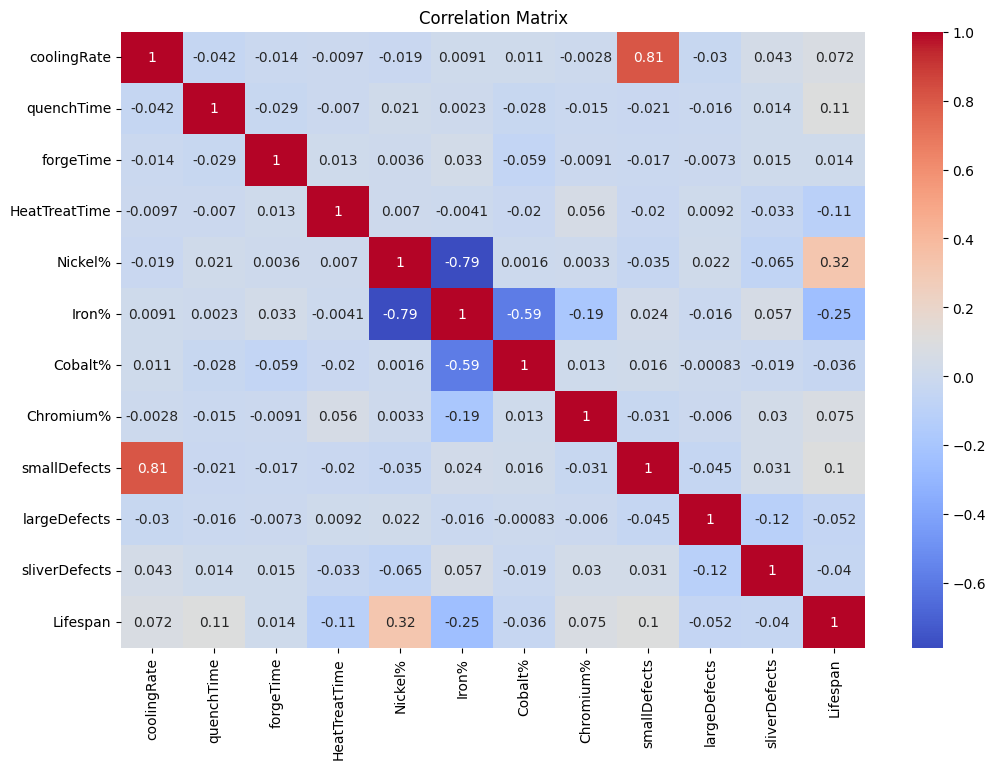

In [66]:
# Include 'Lifespan' in the correlation matrix
numerical_cols_with_target = numerical_features + ['Lifespan']
corr_matrix = df[numerical_cols_with_target].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [67]:
reg_df = df_transformed.copy()

numerical_features = [col for col in reg_df.columns if reg_df[col].dtype in ['int64', 'float64'] and col != 'Lifespan']
categorical_features = reg_df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns:")
for col in categorical_features:
    print(f"- {col}")
print(f"Total columns: {len(categorical_features)}")
print(f"\nNumerical columns:")
for col in numerical_features:
    print(f"- {col}")
print(f"Total columns: {len(numerical_features)}")

Categorical columns:
- partType
- microstructure
- seedLocation
- castType
Total columns: 4

Numerical columns:
- quenchTime
- Nickel%
- Iron%
- Cobalt%
- Chromium%
- largeDefects
- forgeTime
- HeatTreatTime
- sliverDefects
- coolingRate^{1}
- coolingRate^{2}
- smallDefects^{1}
- smallDefects^{2}
Total columns: 13


To find the best encoding for the this dataset, I have developed a Python script that iterates through all the possible encodings and calculates the accuracy of each encoding. The script then returns the encoding that has the highest accuracy. This [`Encoding.py`](./Encoding.py) script is available in the Solutions folder of this repository. This specific script is using a **Random Forest Regressor** model to identify whether the data work best with ordinal or non-ordinal encoding or hybrid approach.

In [68]:
# Define the script file with relative path
script_file = 'Encoding.py'

def execute_script(script_file):
    if os.path.exists(script_file):
        # Execute the script using exec() or by importing it
        with open(script_file) as script_file:
            exec(script_file.read())
    else:
        print(f"Script {script_file} not found. Moving onto the next block.")

# Call the function
# execute_script(script_file)  # Uncomment to execute the script

From the above, we can see that the Random Forest Regressor model using `One-Hot` encoding has shown the best performance with an $\text{R}^2$ score of $0.94$, $\text{RMSE}$ of $81.78$ and $\text{MAE}$ of $64.77$. Therefore we can conclude that the `One-Hot` encoding is the best encoding method for this dataset.

In [69]:
# Bin 'Lifespan' into quartiles
reg_df['Lifespan_bin'] = pd.qcut(reg_df['Lifespan'], q=4, duplicates='drop')

# First, split into training and temp (validation + test)
reg_train_df, temp_df = train_test_split(
    reg_df,
    test_size=0.3,
    stratify=reg_df['Lifespan_bin'],
    random_state=random_state
)

# Then, split temp_df equally into validation and test sets
reg_val_df, reg_test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Lifespan_bin'],
    random_state=random_state
)

# Remove the temporary DataFrame
del temp_df

# Optionally, drop the temporary columns
reg_train_df = reg_train_df.drop(columns=['Lifespan_bin'])
reg_val_df = reg_val_df.drop(columns=['Lifespan_bin'])
reg_test_df = reg_test_df.drop(columns=['Lifespan_bin'])

train_shape, val_shape, test_shape = reg_train_df.shape, reg_val_df.shape, reg_test_df.shape
print(f"Training set shape   : {train_shape}")
print(f"Validation set shape : {val_shape}")
print(f"Test set shape       : {test_shape}")


Training set shape   : (700, 18)
Validation set shape : (150, 18)
Test set shape       : (150, 18)


Here, we are splitting the data into common train, validation and test sets with split ratio of $0.7$, $0.15$ and $0.15$ respectively. We are also using stratification to ensure that the distribution of the target variable is similar in all the sets especially in the train set. Furthermore, we have two additional features which extracted using the polynomial features of `coolingRate` and `smallDefects` features.

In [70]:
reg_train_df.isnull().sum()

quenchTime          0
Nickel%             0
Iron%               0
Cobalt%             0
Chromium%           0
largeDefects        0
Lifespan            0
partType            0
microstructure      0
forgeTime           0
HeatTreatTime       0
sliverDefects       0
seedLocation        0
castType            0
coolingRate^{1}     0
coolingRate^{2}     0
smallDefects^{1}    0
smallDefects^{2}    0
dtype: int64

In [ ]:
def one_hot_encoding(df, categorical_features):
    # Creating a copy of the dataframe to ensure we maintain the original intact
    onehot_encoded_df = df.copy()

    # Initialize and fit the encoder
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int, drop=None)
    
    # Reshape the data to handle multiple categorical columns
    encoded_data = ohe.fit_transform(onehot_encoded_df[categorical_features].values)

    # Convert to DataFrame with feature names and preserve the index
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=ohe.get_feature_names_out(categorical_features),
        index=onehot_encoded_df.index  # Add this line to preserve the index
    )

    # Combine with non-categorical columns if needed
    onehot_encoded_df = pd.concat(
        [onehot_encoded_df.drop(columns=categorical_features), encoded_df], 
        axis=1,
        verify_integrity=True  # Add this to ensure proper alignment
    )

    return onehot_encoded_df

In [72]:
onehot_train_df = one_hot_encoding(reg_train_df, categorical_features)

display(onehot_train_df.head(10))

quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
589        0.93    62.70  24.91     7.76       4.63             0   1371.79   
64         2.17    51.30  34.60    11.10       3.00             0   1666.64   
549        4.28    61.28  28.64     7.49       2.59             0   2055.29   
697        2.26    64.48  15.63    18.24       1.65             0   1732.59   
987        3.77    58.14  30.93     7.50       3.43             0    958.06   
112        0.53    62.41  17.62    17.84       2.13             0    876.66   
74         0.71    63.54  22.48    10.84       3.14             0   1983.69   
301        2.89    56.53  27.59    12.20       3.68             0   1001.23   
183        2.45    69.85  10.86    15.52       3.77             2   1109.88   
715        1.97    68.08  17.35    13.17       1.40             0   1142.03   

     forgeTime  HeatTreatTime  sliverDefects  ...  partType_Nozzle  \
589       1.14          43.30              0  ...                0   
64        6.54          20.03              0  ...                1   
549       2.77          29.03              0  ...                1   
697       5.53          33.70              0  ...                0   
987       6.06          58.31              0  ...                0   
112       1.75          51.54              0  ...                0   
74        7.68           3.77              0  ...                1   
301       8.67           7.64              0  ...                0   
183       9.04          19.76              0  ...                1   
715       3.59          18.48              0  ...                0   

     partType_Valve  microstructure_colGrain  microstructure_equiGrain  \
589               1                        0                         1   
64                0                        0                         1   
549               0                        0                         0   
697               0                        0                         0   
987               0                        0                         1   
112               1                        0                         0   
74                0                        0                         0   
301               0                        0                         1   
183               0                        0                         1   
715               0                        0                         1   

     microstructure_singleGrain  seedLocation_Bottom  seedLocation_Top  \
589                           0                    0                 1   
64                            0                    1                 0   
549                           1                    1                 0   
697                           1                    0                 1   
987                           0                    1                 0   
112                           1                    0                 1   
74                            1                    1                 0   
301                           0                    0                 1   
183                           0                    1                 0   
715                           0                    0                 1   

     castType_Continuous  castType_Die  castType_Investment  
589                    0             1                    0  
64                     1             0                    0  
549                    1             0                    0  
697                    1             0                    0  
987                    0             0                    1  
112                    0             0                    1  
74                     1             0                    0  
301                    0             1                    0  
183                    0             1                    0  
715                    1             0                    0  

[10 rows x 26 columns]

In [73]:
onehot_train_df.isnull().sum()

quenchTime                    0
Nickel%                       0
Iron%                         0
Cobalt%                       0
Chromium%                     0
largeDefects                  0
Lifespan                      0
forgeTime                     0
HeatTreatTime                 0
sliverDefects                 0
coolingRate^{1}               0
coolingRate^{2}               0
smallDefects^{1}              0
smallDefects^{2}              0
partType_Blade                0
partType_Block                0
partType_Nozzle               0
partType_Valve                0
microstructure_colGrain       0
microstructure_equiGrain      0
microstructure_singleGrain    0
seedLocation_Bottom           0
seedLocation_Top              0
castType_Continuous           0
castType_Die                  0
castType_Investment           0
dtype: int64

In [74]:
# Features (X) and target (y)
X_train = onehot_train_df.drop(columns=['Lifespan'])   # Features excluding the target variable
y_train = onehot_train_df['Lifespan']                  # Target variable

# Apply one-hot encoding to the test set and test the model
onehot_test_df = one_hot_encoding(reg_test_df, categorical_features)

# Features (X) and target (y)
X_test = onehot_test_df.drop(columns=['Lifespan'])   # Features excluding the target variable
y_test = onehot_test_df['Lifespan']                  # Target variable

In [75]:
# Initialize the Linear Regression model
LinRegModel = LinearRegression(n_jobs=-1)

# Fit the model
LinRegModel.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

Here the parameter `n_jobs` is set to `-1`, which means that all available cores will be used for parallel processing.

--- Linear Regression Model (Training Set) Evaluation Metrics ---

RMSE: 170.54
R²  : 0.75
MAE : 139.05


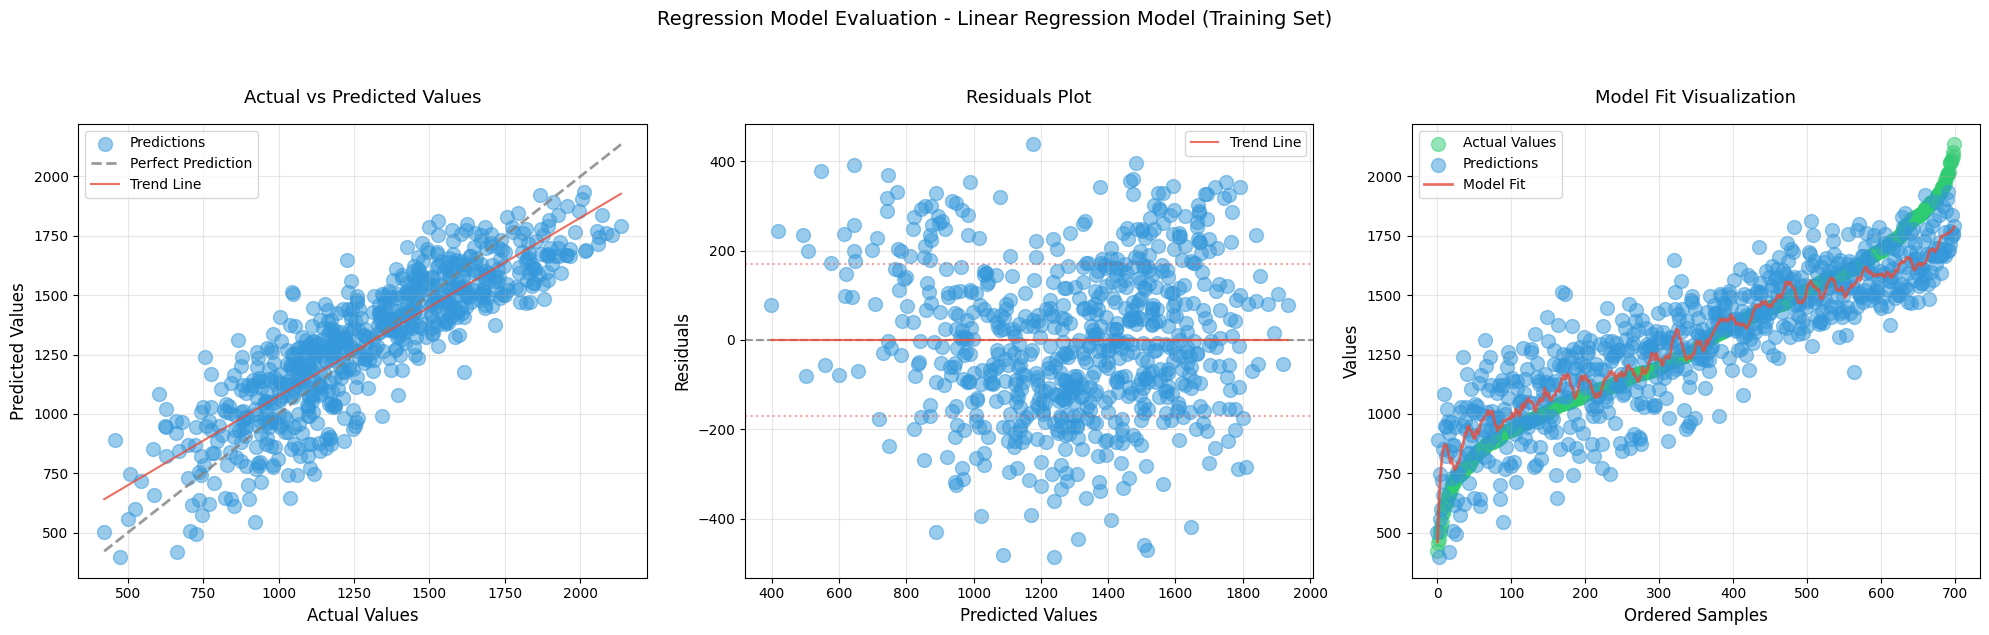

In [88]:
# Evaluate the model on the training set
regression_evaluation(LinRegModel, X_train, y_train, "Linear Regression Model (Training Set)")

--- Linear Regression Model (Test Set) Evaluation Metrics ---

RMSE: 173.29
R²  : 0.76
MAE : 139.51


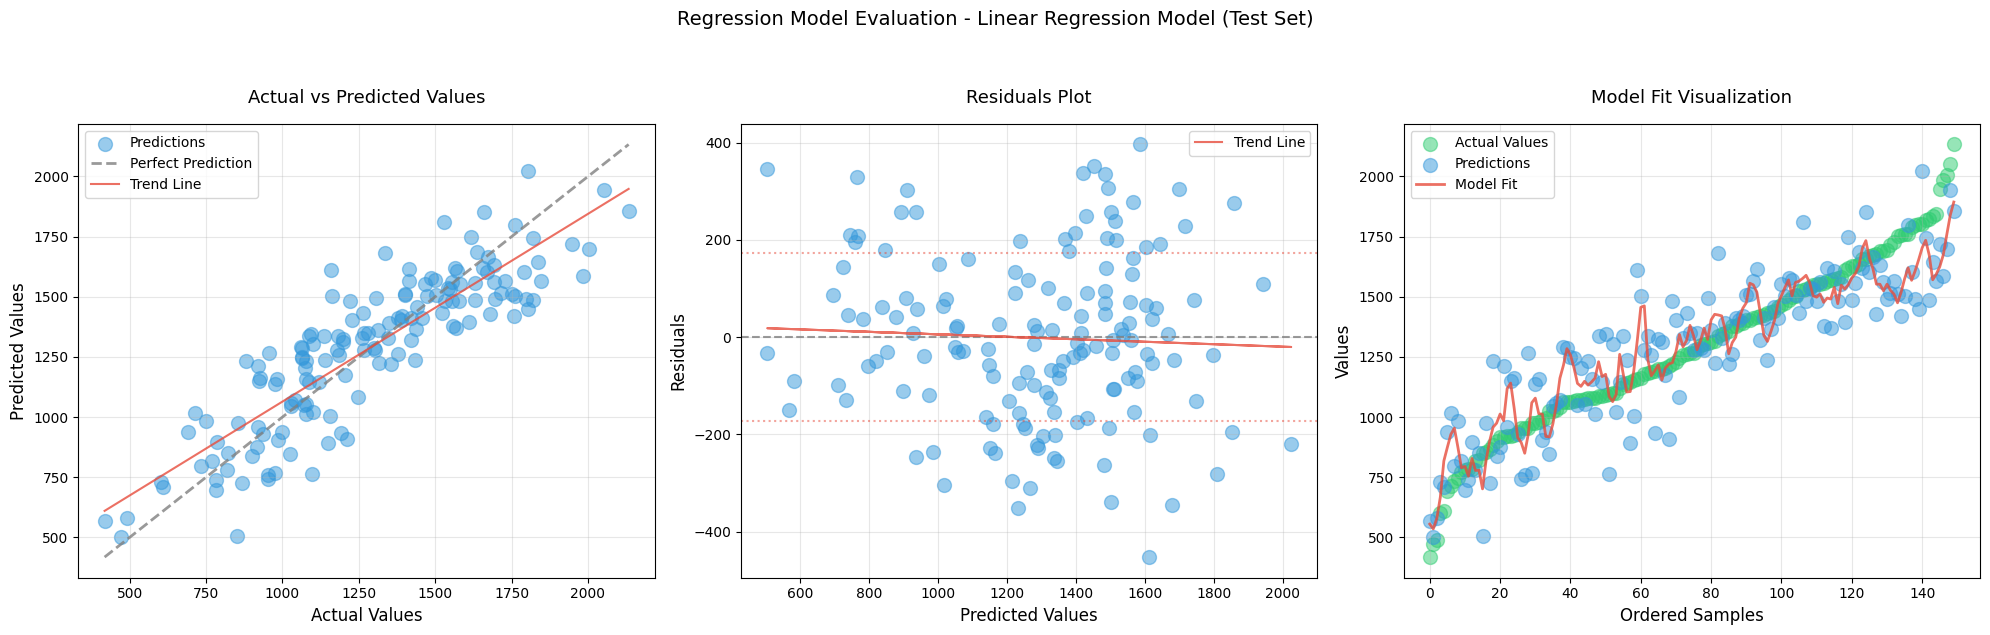

In [77]:
# Evaluate the model on the test set
regression_evaluation(LinRegModel, X_test, y_test, "Linear Regression Model (Test Set)")

In [78]:
# Initializing Random Forest Regressor
RFModel = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model
RFModel.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

Here the parameters such as `n_estimators` and `random_state` are set to default values. The `n_estimators` parameter specifies the number of trees in the forest. The `random_state` parameter is used to set the random seed for reproducibility.

--- Random Forest Regressor (Training Set) Evaluation Metrics ---

RMSE: 31.85
R²  : 0.99
MAE : 24.74


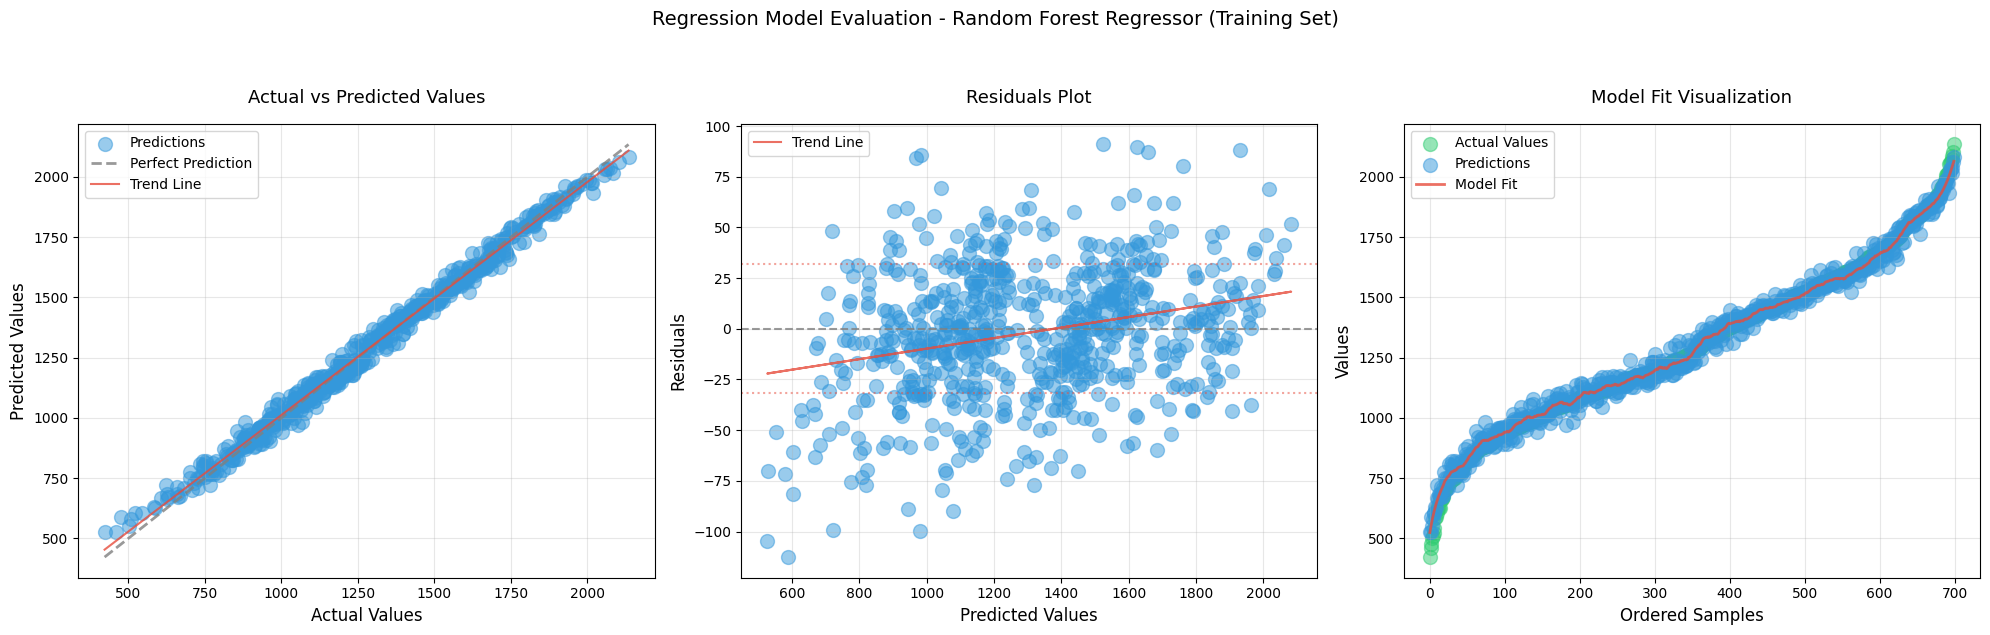

In [87]:
# Evaluate the model on the training set
regression_evaluation(RFModel, X_train, y_train, "Random Forest Regressor (Training Set)")

--- Random Forest Regressor (Test Set) Evaluation Metrics ---

RMSE: 86.87
R²  : 0.94
MAE : 69.72


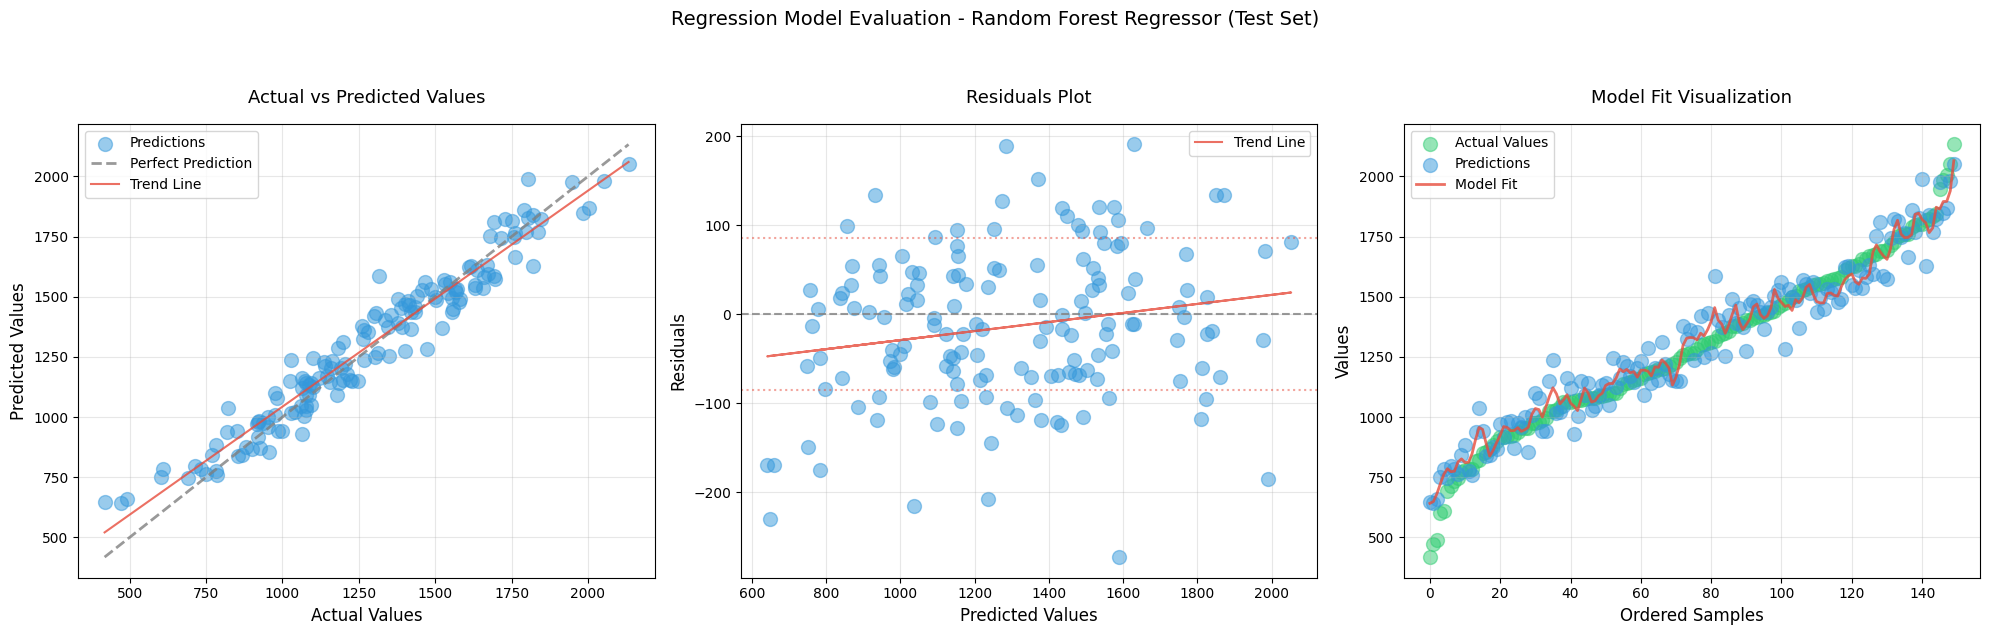

In [80]:
regression_evaluation(RFModel, X_test, y_test, "Random Forest Regressor (Test Set)")

Here we can see that the accuracy drops because the model was overfitted on training set. Even though the model was overfitted on training set, it is still able to predict the test set with a good accuracy.

In [81]:
XGBModel = XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# Fit the model
XGBModel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

--- XGBoost Regressor (Training Set) Evaluation Metrics ---

RMSE: 0.52
R²  : 1.00
MAE : 0.33


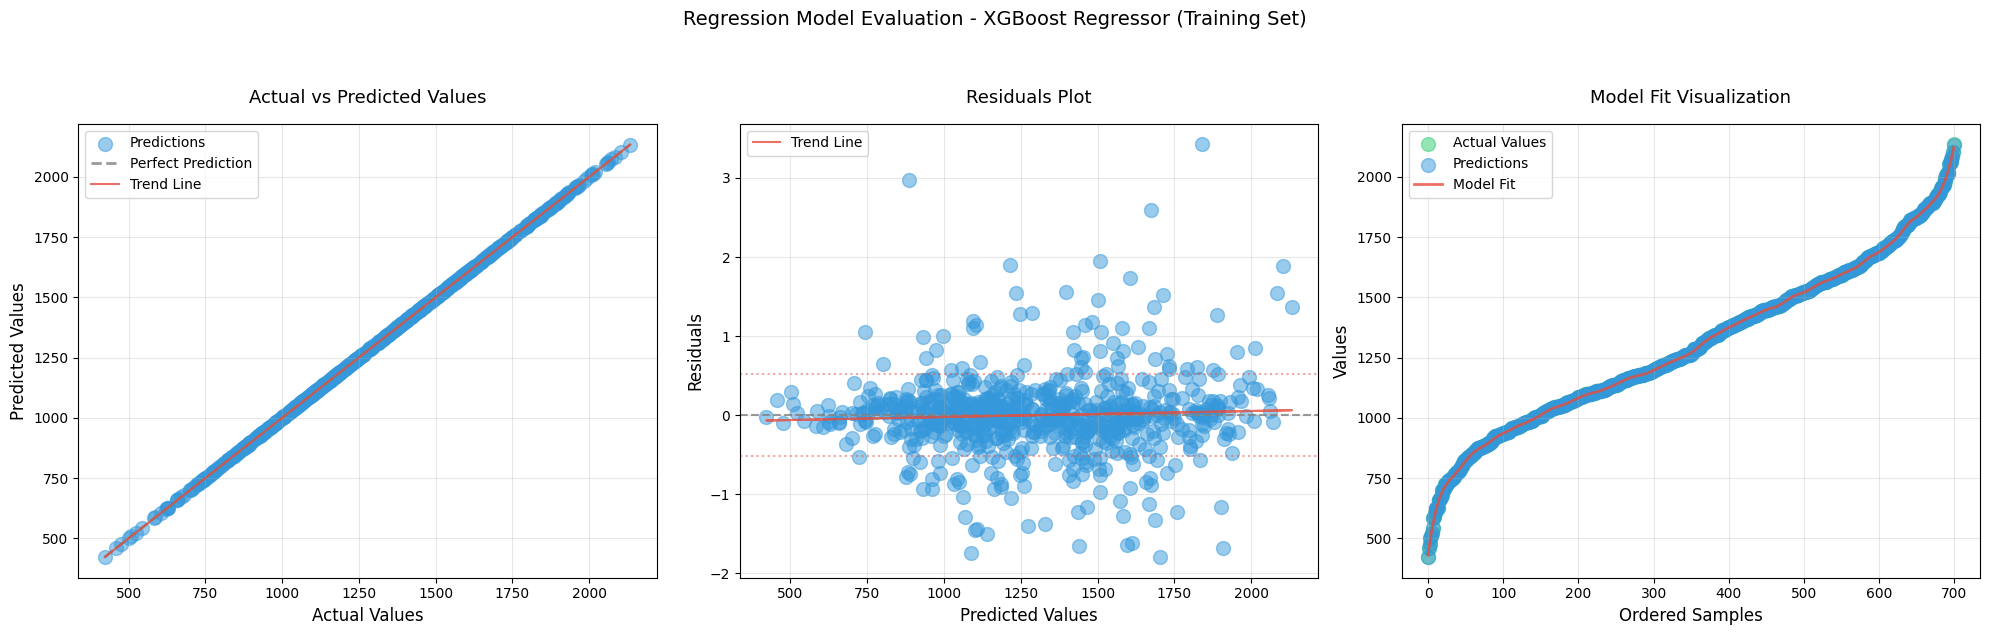

In [82]:
regression_evaluation(XGBModel, X_train, y_train, "XGBoost Regressor (Training Set)")

--- XGBoost Regressor (Test Set) Evaluation Metrics ---

RMSE: 65.68
R²  : 0.97
MAE : 48.92


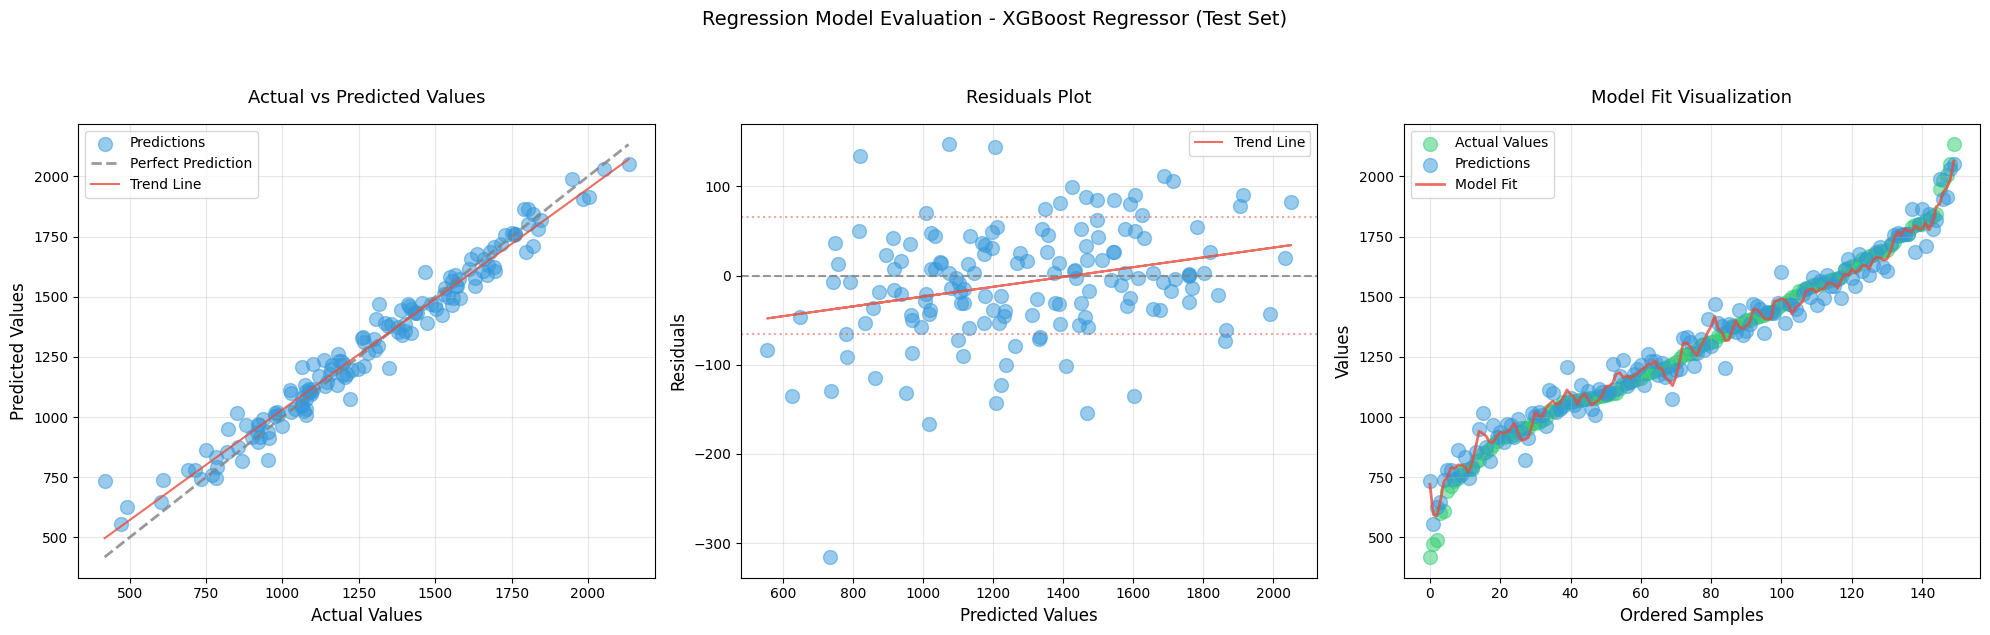

In [83]:
regression_evaluation(XGBModel, X_test, y_test, "XGBoost Regressor (Test Set)")

In [84]:
input_dim = X_train.shape[1]

NNModel = tf.keras.Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
NNModel.compile(optimizer="adam", loss="mse")

NNModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 224 (896.00 B)

In [85]:
NNModel.fit(X_train, y_train, epochs=100, batch_size=70)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - loss: 1763481.7500
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 1763146.8750
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 1762870.2500
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 1762596.2500
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 1762384.2500
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 1762001.3750
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 1761872.3750
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1761479.2500
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1761090.7500
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 1760732.2500
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 1760342.1250
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 1759891.1250
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 1759588.0000
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━